# Training and Validation with optax

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

import optax
from flax.training.early_stopping import EarlyStopping

import jax
import jax.numpy as jnp

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.loader import Loader
from validphys import convolution
from validphys.convolution import evolution

from super_net.data_batch import DataBatch
from super_net.core import NewDataGroupSpec


## Metadata and Data

In [6]:
DIS_datasets = [{'dataset': 'NMCPD_dw_ite'}, {'dataset': 'SLACP_dwsh'},
                      {'dataset': 'SLACD_dw_ite'}, {'dataset': 'BCDMSP_dwsh'},
                      {'dataset': 'BCDMSD_dw_ite'}, {'dataset': 'CHORUSNUPb_dw_ite'},
               {'dataset': 'CHORUSNBPb_dw_ite'}, {'dataset': 'NTVNUDMNFe_dw_ite', 'cfac': ['MAS']},
               {'dataset': 'HERACOMBNCEM'}, {'dataset': 'HERACOMBNCEP575'}, 
               {'dataset': 'HERACOMBNCEP820'}, {'dataset': 'HERACOMBNCEP920'}, 
               {'dataset': 'HERACOMBCCEP'}, {'dataset': 'HERACOMB_SIGMARED_C'},
               {'dataset': 'HERACOMBCCEM'}, {'dataset': 'HERACOMBNCEP460'}, {'dataset':'HERACOMB_SIGMARED_B'},
               {'dataset':'HERACOMB_SIGMARED_B'}, {'dataset':'NMC'}, 
               {'dataset': 'NTVNBDMNFe_dw_ite', 'cfac': ['MAS']}]


inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": DIS_datasets,
    "use_cuts": "internal",
    "theoryid": 400
}

In [7]:
data = API.data(**inp)

In [8]:
new_data = NewDataGroupSpec(name = "data", datasets = data.datasets, dsinputs = data.dsinputs)


Ndat = sum([cd.ndata for cd in new_data.load_commondata_instance()])

def len_training_set(Ndat, test_size, random_state):
    idx_train, idx_test = train_test_split(jnp.arange(Ndat), test_size=test_size, random_state=random_state)
    return len(idx_train), len(idx_test)
test_size=0.2
random_state=42
N_train, N_test = len_training_set(Ndat, test_size, random_state)

2023-06-14 16:50:25.303559: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-06-14 16:50:25.365598: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


In [9]:
# Random Initial Weights
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")

# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

xgrid = load_fktable(data.datasets[0].fkspecs[0]).xgrid

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xgrid, [1.65]).squeeze(-1)
rng = jax.random.PRNGKey(0xDEADBEEF)
# initial weights for weight minimization
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)


chi2_contribs_data_mini_batch = new_data.make_chi2_data_mini_batch(train_val_split=True, test_size=test_size, random_state=random_state)

chi2_validation = new_data.make_chi2_validation(test_size=test_size, random_state=random_state)


LHAPDF 6.5.0 loading all 101 PDFs in set 210713-n3fit-001
210713-n3fit-001, version 1; 101 PDF members


In [45]:
@jax.jit
def loss_data_batch(weights,batch_idx):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data_mini_batch(pdf,batch_idx)

@jax.jit
def loss_validation(weights):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_validation(pdf)

# @jax.jit
# def update_weights(step,opt_state,batch_idx):
#     params  = get_params(opt_state)
#     return opt_update(step, jax.grad(loss_data_batch)(params,batch_idx),opt_state)

def fit(nr_epochs: int, num_batches, batches, batch_size, params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    """"""
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params,opt_state,batch_idx):
        loss_value, grads = jax.value_and_grad(loss_data_batch)(params,batch_idx)
        updates, opt_state = optimizer.update(grads,opt_state,params)
        params = optax.apply_updates(params,updates)
        return params, opt_state, loss_value
    
    loss = []
    val_loss = []
    
    early_stop = EarlyStopping(min_delta=1e-4, patience=5)
    
    for i in range(nr_epochs):
        
        epoch_loss = 0
        epoch_val_loss = 0
        
        for _ in range(num_batches):
            batch = next(batches)
            params, opt_state, loss_value = step(params, opt_state, batch)
            epoch_loss+=loss_value / batch_size
        
        epoch_loss /= num_batches
        
        loss.append(epoch_loss)
        epoch_val_loss += loss_validation(params) / (N_test)
        val_loss.append(epoch_val_loss)        
        
        
        if i % 100 == 0:

            print(f'step {i}, loss: {epoch_loss:.3f}, validation_loss: {epoch_val_loss:.3f}')        
        
        
            _, early_stop = early_stop.update(epoch_val_loss)
            print(f"epoch:{i}, early_stop: {early_stop}")

            if early_stop.should_stop:
                print('Met early stopping criteria, breaking...')
                break
            
    return params, loss, val_loss


In [46]:
batch_size = 128


databatch = DataBatch(Ndat=N_train,batch_size=batch_size,seed=0)
batches = databatch.data_batch_stream_index()
num_batches = databatch.num_batches()

initial_params = weight_base
nr_epochs = 2000

optimizer = optax.adam(learning_rate=5e-4)
params, loss, val_loss = fit(nr_epochs, num_batches, batches, batch_size, initial_params, optimizer)

step 0, loss: 1.213, validation_loss: 1.140
epoch:0, early_stop: EarlyStopping(min_delta=0.0001, patience=5, best_metric=Array(1.1401598, dtype=float32), patience_count=0, should_stop=False)
step 100, loss: 1.209, validation_loss: 1.120
epoch:100, early_stop: EarlyStopping(min_delta=0.0001, patience=5, best_metric=Array(1.1196663, dtype=float32), patience_count=0, should_stop=False)
step 200, loss: 1.183, validation_loss: 1.105
epoch:200, early_stop: EarlyStopping(min_delta=0.0001, patience=5, best_metric=Array(1.105071, dtype=float32), patience_count=0, should_stop=False)
step 300, loss: 1.168, validation_loss: 1.102
epoch:300, early_stop: EarlyStopping(min_delta=0.0001, patience=5, best_metric=Array(1.1016748, dtype=float32), patience_count=0, should_stop=False)
step 400, loss: 1.162, validation_loss: 1.091
epoch:400, early_stop: EarlyStopping(min_delta=0.0001, patience=5, best_metric=Array(1.0911813, dtype=float32), patience_count=0, should_stop=False)
step 500, loss: 1.152, validat

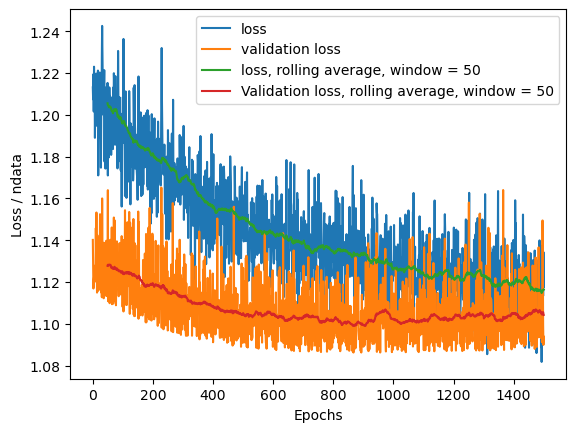

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

loss = np.array(loss)
val_loss = np.array(val_loss)

df = pd.DataFrame({"loss":loss})
df_val = pd.DataFrame({"val_loss":val_loss})

fig, ax = plt.subplots()

ax.plot(loss, label = "loss")
ax.plot(val_loss, label="validation loss")

wind_size = 50

ax.plot(df.rolling(wind_size).mean().to_numpy(), label = f"loss, rolling average, window = {wind_size}")
ax.plot(df_val.rolling(wind_size).mean().to_numpy(), label = f"Validation loss, rolling average, window = {wind_size}")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss / ndata")
ax.legend()

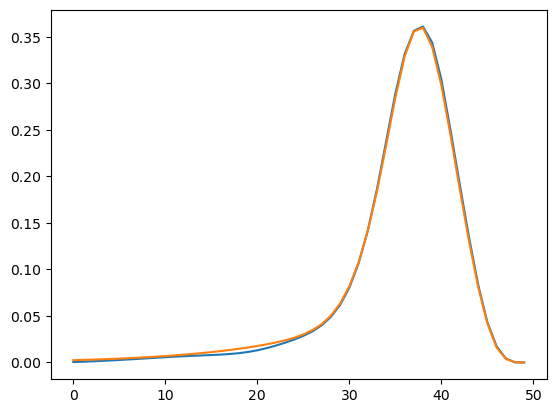

In [57]:
n=9
fig, ax = plt.subplots()
ax.plot(jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :])
ax.plot(INPUT_GRID[0, n,:])